# Machine Learning Online Class - Exercise 3 | Part 1: One-vs-all

In [1]:
import numpy as np
from scipy.optimize import fmin_bfgs
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt

In [2]:
#Setup the parameters you will use for this part of the exercise
input_layer_size = 400  #20x20 Input Images of Digits
num_labels = 10         #10 labels, from 0 to 9 (we have to remapped from '10' to '0')

## =========== Part 1: Loading and Visualizing Data =============

In [3]:
#load data from matlab file
data = loadmat("ex3data1.mat")
X = data['X']
yp = data['y']
y = np.array([[0] if i == 10 else [i] for i in yp])
print(X.shape,y.shape)

(5000, 400) (5000, 1)


In [4]:
#randomly select 100 data points to display
rand_indices = random.sample(range(X.shape[0]), 100)
sel = X[rand_indices,:]

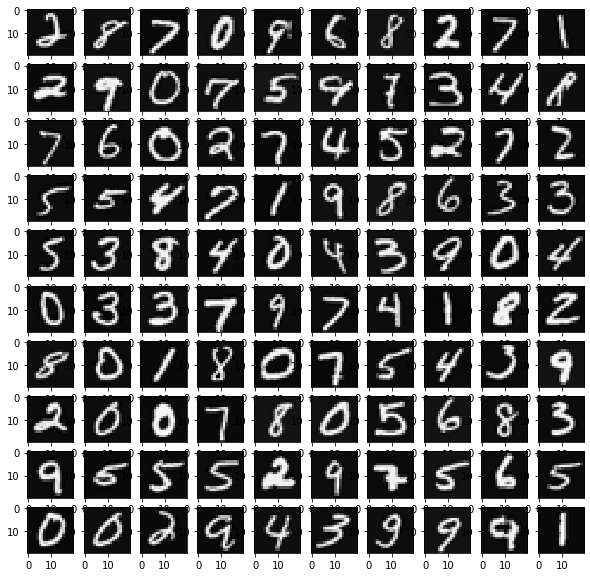

In [5]:
#Display the data as images
fig0, ax = plt.subplots(10,10,figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(sel[10*i+j].reshape(20,20, order='F'), cmap='gray')#order 'F' orders by column, like fortran

## ============ Part 2a: Vectorize Logistic Regression ============

In [6]:
#Logistic function
def logistic(theta, x):
    dot = np.matmul(x, theta)
    if type(dot) == np.ndarray:
        dot = dot[0]
    return 1.0 / (1 + np.exp(-dot))

def hv(theta, X):
    return np.array([[logistic(theta, x) for x in X]]).T

#Regularized cost function J
def Jreg(theta, X, y, l):
    hvec = hv(theta.reshape(X.shape[1],1), X)
    one = np.ones((y.shape[0],1))
    hvec1 = one-hvec
    logh = np.log(hvec)
    logh1 = np.log(hvec1)
    y1 = one-y
    
    dot1 = np.matmul(y.T,logh)
    dot2 = np.matmul(y1.T,logh1)
    
    thetam = np.copy(theta)
    thetam[0] = 0
    fact = l / (2*y.shape[0])
    tsum = np.sum(fact*thetam**2)
    
    return -(dot1[0][0]+dot2[0][0])/y.shape[0] + tsum

#Gradient of regularized J
def grad_Jreg(theta, X, y, l):
    hvec = hv(theta.reshape(X.shape[1],1), X)
    yh = hvec - y
    grad = []
    for k in range(X.shape[1]):
        xk = X[:,k] #k column as 1d array (row vector)
        grad.append(np.matmul(xk,yh))
        
    thetam = np.copy(theta)
    thetam[0] = 0
    fact = l / y.shape[0]
        
    return (np.asarray(grad)/y.shape[0]).flatten() + fact*thetam

In [7]:
theta_t = np.array([-2,-1,1,2])
X_t = np.array([i for i in range(1,16)]).reshape(5,3,order='F')/10 #order 'F' orders by column, like fortran
X_t = np.insert(X_t, 0, np.ones(5), axis=1)
y_t = np.array([[1],[0],[1],[0],[1]])
lambda_t = 3
J = Jreg(theta_t, X_t, y_t, lambda_t)
grad = grad_Jreg(theta_t, X_t, y_t, lambda_t)

print("Cost: {0:.6f}".format(J))
print("Expected cost: 2.534819")
print("Gradients: ")
print(grad)
print("Expected gradients:")
print("0.146561 -0.548558 0.724722 1.398003")

Cost: 2.534819
Expected cost: 2.534819
Gradients: 
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:
0.146561 -0.548558 0.724722 1.398003


## ============ Part 2b: One-vs-All Training ============

In [8]:
# Add bias column to X
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)

In [9]:
#Train 10 logistic regression classifiers, one for each digit i vs. all other digits j!=i.
#Return the classifiers in a matrix with 10 rows, where the ith row corresponds to the classifier 
# for label i.
#Each pixel is a feature, so each row has 400+1 columns (parameters)

def oneVsAll(X, y, l):
    num_labels = np.unique(y).shape[0]
    all_theta = np.zeros((num_labels, X.shape[1]))
    for i in range(num_labels):
        yi = np.array([1 if x == i else 0 for x in y]).reshape(X.shape[0],1)#column with 1 if digit=i else 0
        theta_in = np.zeros(X.shape[1])
        all_theta[i] = fmin_bfgs(Jreg, theta_in, grad_Jreg, args=(X, yi, l))
    return all_theta

In [10]:
l = 0.1
all_theta = oneVsAll(X, y, l)

Optimization terminated successfully.
         Current function value: 0.008583
         Iterations: 288
         Function evaluations: 289
         Gradient evaluations: 289
Optimization terminated successfully.
         Current function value: 0.013128
         Iterations: 286
         Function evaluations: 287
         Gradient evaluations: 287
Optimization terminated successfully.
         Current function value: 0.050810
         Iterations: 439
         Function evaluations: 440
         Gradient evaluations: 440
Optimization terminated successfully.
         Current function value: 0.057612
         Iterations: 424
         Function evaluations: 425
         Gradient evaluations: 425
Optimization terminated successfully.
         Current function value: 0.033075
         Iterations: 396
         Function evaluations: 397
         Gradient evaluations: 397
Optimization terminated successfully.
         Current function value: 0.054466
         Iterations: 433
         Function ev

## ================ Part 3: Predict for One-Vs-All ================

In [14]:
#Function to predict all the samples in the training set with the trained model
def logi(z):
    return 1.0 / (1 + np.exp(-z))

def predictOneVsAll(all_theta, X):
    M = logi(np.matmul(X,all_theta.T))
    p = np.array([[np.where(row == np.max(row))[0][0]] for row in M])
    return p

In [15]:
pred = predictOneVsAll(all_theta, X)

In [16]:
print("Training set accuracy: {0:.3f}".format(np.mean(pred==y)))

Training set accuracy: 0.965
